In [1]:
import os
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet, tfr_multitaper
from pyprep.prep_pipeline import PrepPipeline
import pickle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

mne.set_log_level('WARNING')

In [2]:
%matplotlib inline

In [4]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


In [9]:
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')
info_test = mne.create_info(ch_names=ch_names[:26], ch_types=ch_types[:26], sfreq=500)
info_test.set_montage(montage=montage, on_missing= 'raise')
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,"26 EEG, 5 EOG, 1 ECG, 1 EMG"
Bad channels,None
EOG channels,"VPVA, VNVB, HPHL, HNHR, OrbOcc"
ECG channels,Erbs
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


ICA without high pass filtering before ICA fitting

In [6]:
a = np.load('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_test_data\preprocessed_tdbrain_prep\sub-19687321\ses-1\eeg\sub-19687321_ses-1_task-restEC_preprocessed.npy', 
            allow_pickle=True)
print(a)

In [111]:
a.preprocessed_raw.plot()

2024-03-08 15:49:05,752 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-08 15:49:05,753 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-08 15:49:05,754 - qdarkstyle - INFO - Found application patches to be applied.


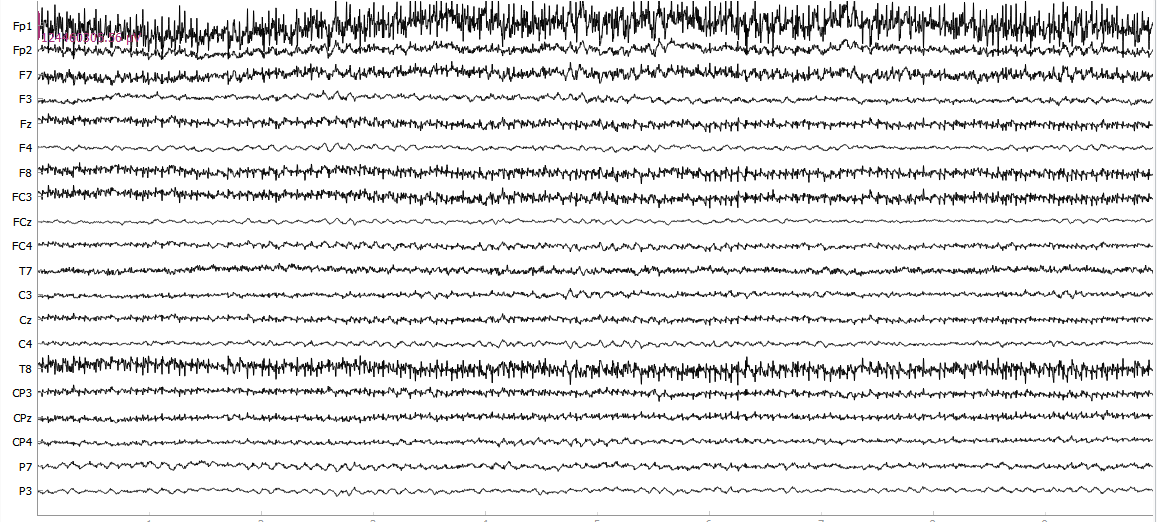

ICA with high pass filtering before ICA fitting

In [109]:
b = np.load('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_test_data\preprocessed_tdbrain_prep\sub-19687321\ses-1\eeg\sub-19687321_ses-1_task-restEC_preprocessed.npy', 
            allow_pickle=True)
print(b)

In [112]:
b.preprocessed_raw.plot()

2024-03-08 15:50:24,591 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-08 15:50:24,592 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-08 15:50:24,593 - qdarkstyle - INFO - Found application patches to be applied.


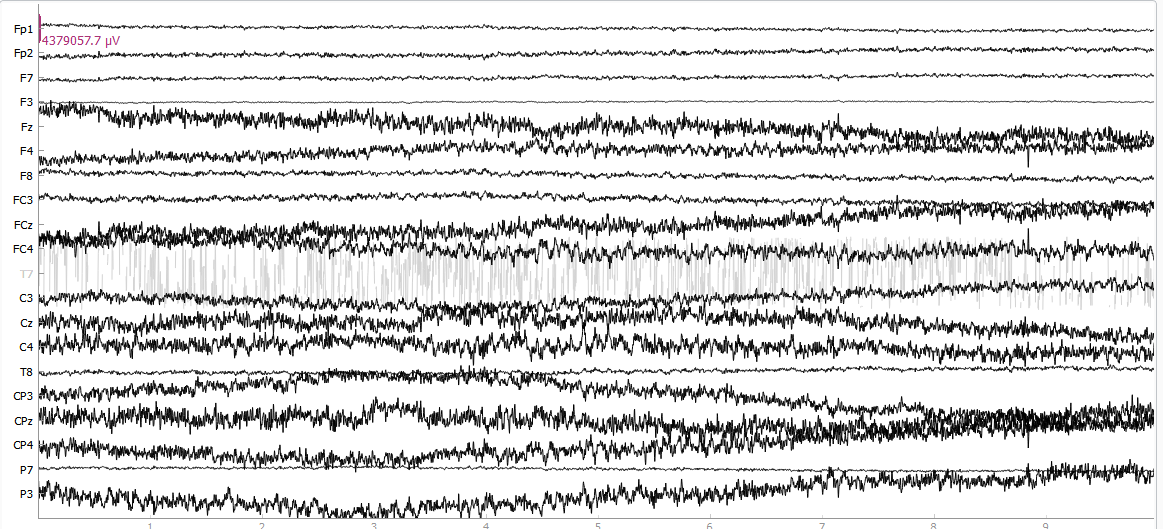

ICA with high pass filtering and subsequenct highpass & lowpass filtering

In [4]:
c = np.load('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_test_data\preprocessed_tdbrain_prep\sub-19687321\ses-1\eeg\sub-19687321_ses-1_task-restEC_preprocessed.npy', 
            allow_pickle=True)
print(c)

In [121]:
c.preprocessed_raw.plot()


2024-03-08 16:05:41,341 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-08 16:05:41,341 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-08 16:05:41,342 - qdarkstyle - INFO - Found application patches to be applied.


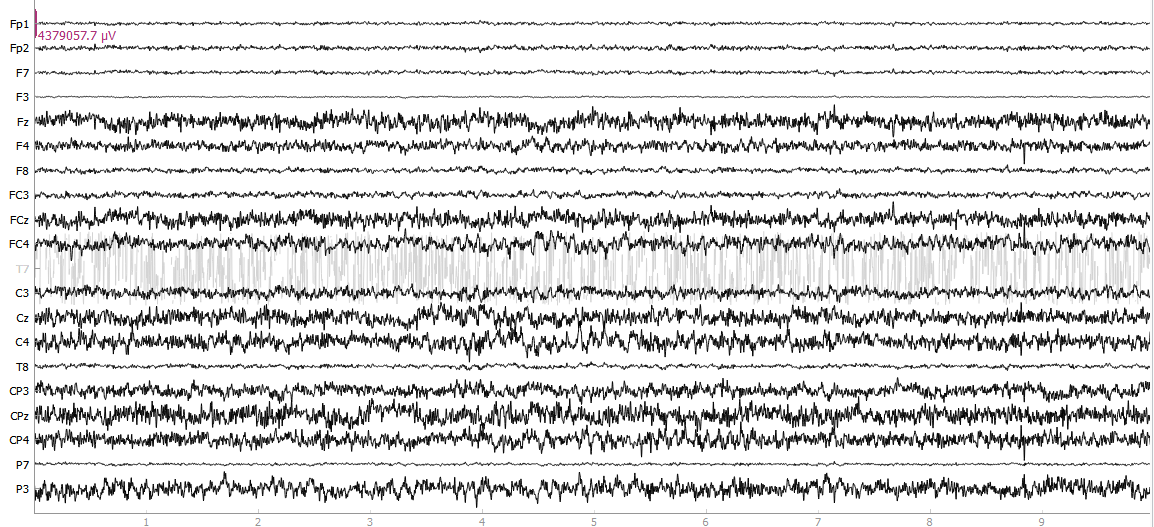

Van Dijk preprocessing:

In [122]:
d = np.load('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed\sub-19687321\ses-1\eeg\sub-19687321_ses-1_task-restEC_eeg_csv_120.03s.npy',
                        allow_pickle=True)
#print(d)

In [120]:
raw = mne.io.RawArray(np.squeeze(d['data'][0, :26, :]), info_test) # load data as MNE object, with the previously created 'info'
raw.plot() # plot the data

2024-03-08 16:04:55,405 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-08 16:04:55,406 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-08 16:04:55,407 - qdarkstyle - INFO - Found application patches to be applied.


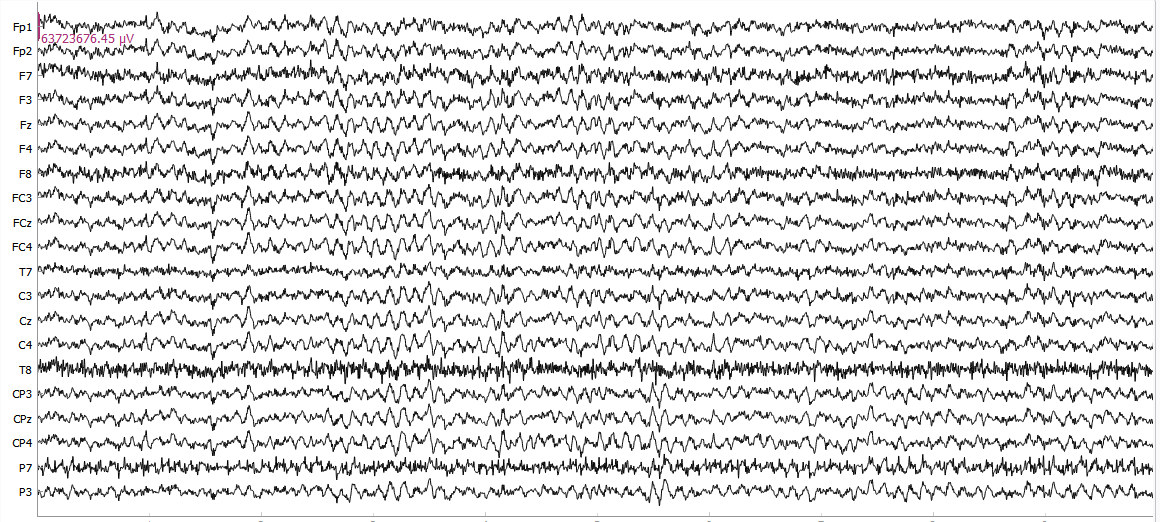

Without preprocessing (only BP filter)

In [14]:
# check without preprocessing
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-19687321\ses-1\eeg\sub-19687321_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
raw.plot(duration=120, scalings={'eeg': 1e2, 'eog': 'auto', 'emg': 'auto', 'ecg': 'auto'})

2024-03-11 13:50:20,832 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-11 13:50:20,833 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-11 13:50:20,834 - qdarkstyle - INFO - Found application patches to be applied.


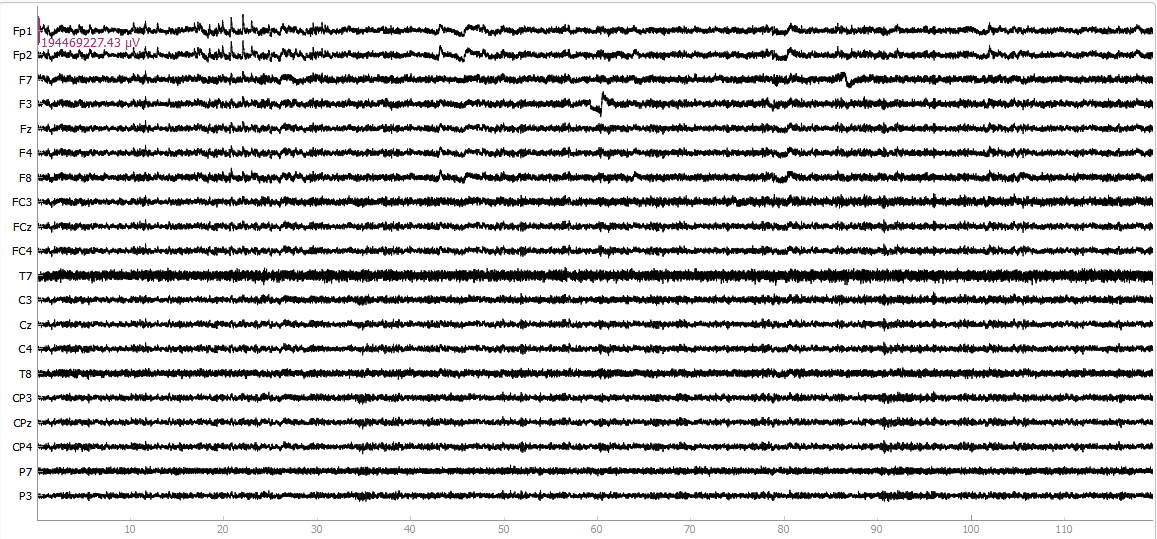

On same scale:
order: 
(own preprocessing, 
van dijk preprocessing, 
no preprocessing)

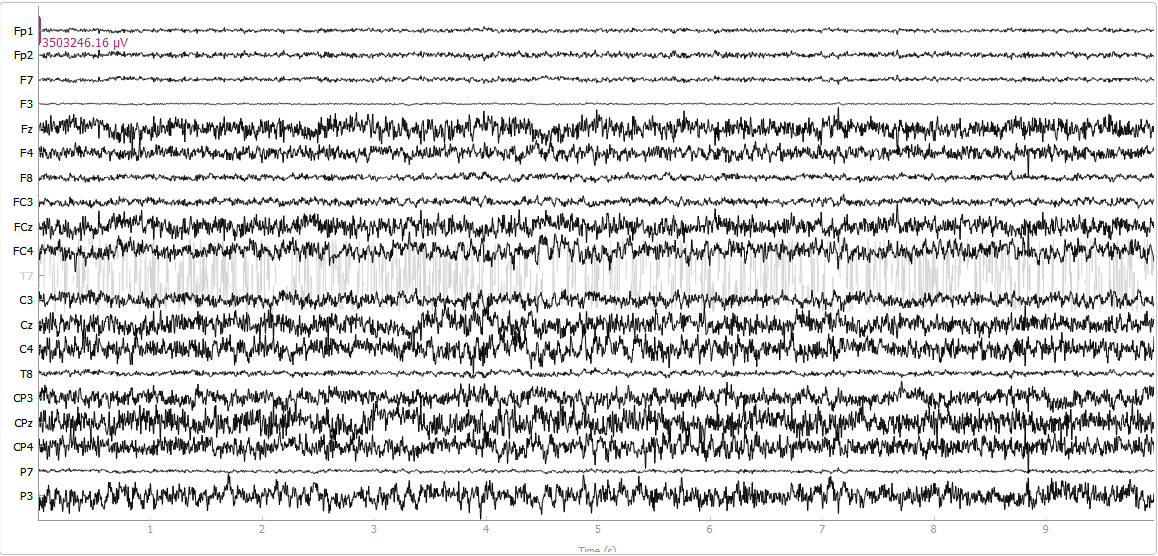

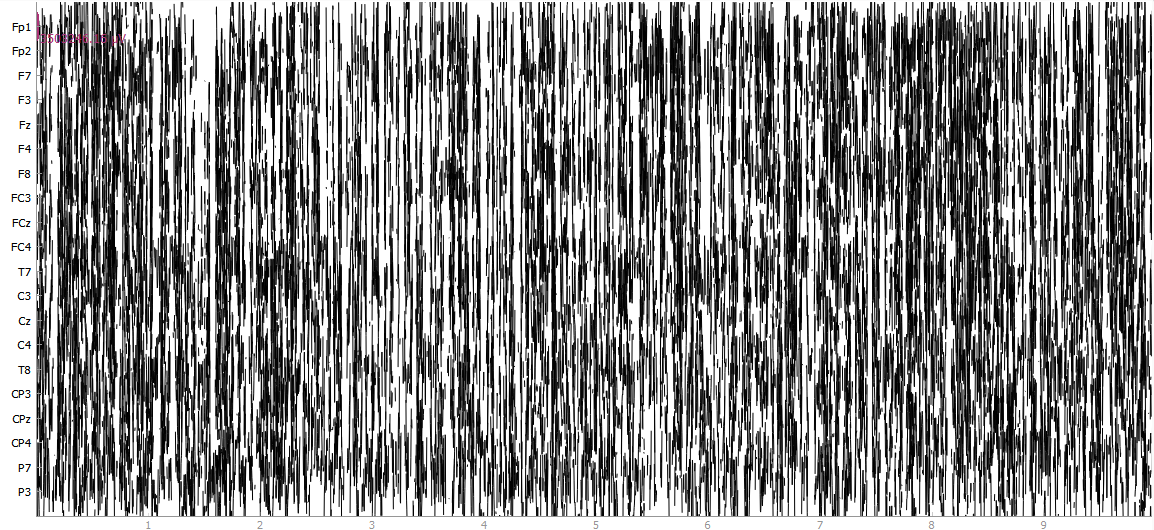

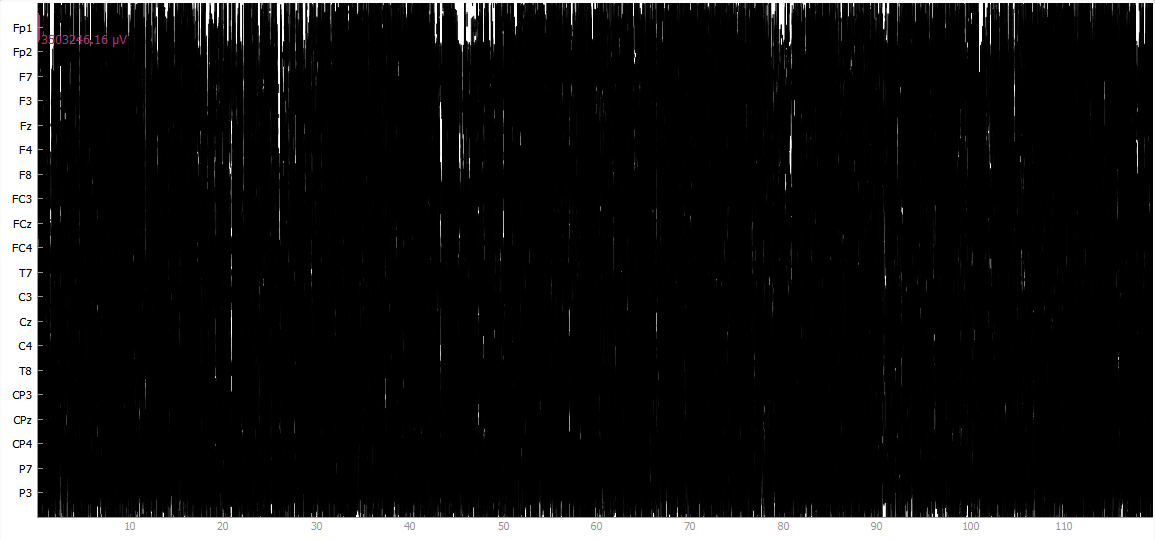

In [3]:
filepath = 'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\TDBRAIN-dataset-derivatives\\preprocessed_own\\sub-19681349\\ses-1\\eeg\\sub-19681349_ses-1_task-restEC_preprocessed.npy'
test = np.load(filepath, allow_pickle = True)

In [4]:
test.preprocessed_raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,"25 EEG, 5 EOG, 1 ECG, 1 EMG"
Bad channels,T7
EOG channels,"VPVA, VNVB, HPHL, HNHR, OrbOcc"
ECG channels,Erbs
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz
